<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">Baseline Models with Player Track Box Score Stats Features</h4>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Baseline-Models"></a>

# Table of Contents

[Setup](#Setup)

[Data](#Data)

[Inspect Training Windows](#Inspect-Training-Windows)

- [Expanding](#Expanding)

- [Rolling](#Rolling)

**[1. Target: Total Points (over / under)](#1.-Target:-Total-Points-(over-/-under))**

- [1.1. Expanding Window](#1.1.-Expanding-Window)

- [1.2. Rolling Window](#1.2.-Rolling-Window)

**[2. Target: Difference in Points (plus / minus)](#2.-Target:-Difference-in-Points-(plus-/-minus))**

- [2.1. Expanding Window](#2.1.-Expanding-Window)

- [2.2. Rolling Window](#2.2.-Rolling-Window)

**[3. Target: Game Winner (moneyline)](#3.-Target:-Game-Winner-(moneyline))**

- [3.1. Expanding Window](#3.1.-Expanding-Window)

- [3.2. Rolling Window](#3.2.-Rolling-Window)

# Setup

[Return to top](#Baseline-Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


# Data

[Return to top](#Baseline-Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [2]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    input_data='../../data/processed/nba_team_matchups_rolling_player_track_box_stats_2021_2024_r10.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'],
    training_season='2021-22',
    feature_prefixes=['ROLL_'],
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 691 games
Total number of games across sampled seasons: 3058 games


In [3]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.tail()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-03,0.702,0.522,0.208,0.367,0.494,0.583,0.44,0.434,0.894,0.643,0.523,0.672,0.461,0.477,0.601,0.743,0.744,0.612,0.463,0.564,0.531,0.284,0.432,0.299,0.546,0.362,0.531,0.623,0.529,0.540,0.573,0.592,0.491,0.237,0.786,0.736,0.422,0.500,0.577,0.617,218
2024-02-04,0.634,0.474,0.235,0.356,0.515,0.883,0.54,0.477,0.889,0.636,0.473,0.772,0.457,0.560,0.529,0.703,0.869,0.728,0.482,0.551,0.379,0.203,0.319,0.163,0.357,0.812,0.306,0.369,0.533,0.693,0.465,0.910,0.577,0.230,0.982,1.086,0.500,0.546,0.630,0.775,252
2024-02-04,0.599,0.483,0.238,0.376,0.366,0.633,0.50,0.282,0.778,0.536,0.464,0.613,0.548,0.503,0.693,0.770,0.806,0.584,0.575,0.591,0.589,0.423,0.384,0.355,0.397,0.212,0.612,0.412,0.458,0.493,0.446,0.659,0.432,0.246,0.650,0.695,0.556,0.600,0.613,0.550,210
2024-02-04,0.654,0.483,0.194,0.342,0.481,0.367,0.52,0.455,0.511,0.400,0.384,0.570,0.422,0.507,0.513,0.577,0.669,0.492,0.531,0.360,0.700,0.500,0.352,0.372,0.661,0.400,0.510,0.761,0.658,0.580,0.581,0.633,0.568,0.333,0.791,0.756,0.611,0.681,0.589,0.658,214
2024-02-04,0.559,0.570,0.402,0.549,0.406,0.483,0.40,0.334,0.611,0.414,0.262,0.672,0.622,0.717,0.621,0.743,0.562,0.468,0.454,0.700,0.569,0.377,0.374,0.320,0.488,0.525,0.286,0.546,0.546,0.473,0.496,0.578,0.427,0.243,0.655,0.635,0.639,0.750,0.514,0.540,222


In [5]:
pm_scaled_df.head()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,0.635,0.522,0.229,0.345,0.488,0.500,0.6,0.402,0.611,0.929,0.916,0.619,0.391,0.267,0.676,0.788,0.438,0.16,0.720,0.691,0.454,0.032,0.710,0.309,0.567,0.375,0.408,0.604,0.708,0.267,0.231,0.601,0.682,0.391,0.855,0.787,0.056,0.423,0.000,0.635,29.0
2021-10-23,0.588,0.565,0.375,0.564,0.364,0.167,0.8,0.192,0.667,0.214,0.156,0.526,0.696,0.667,0.761,0.784,1.000,1.00,0.352,0.745,0.553,0.613,0.000,0.180,0.401,0.250,0.816,0.457,0.500,0.667,0.731,0.584,0.409,0.130,0.841,0.761,0.611,0.423,1.000,0.577,7.0
2021-10-23,0.592,0.652,0.104,0.291,0.576,0.167,0.6,0.430,1.000,0.643,0.451,0.768,0.739,0.800,0.712,0.860,0.500,0.52,0.291,0.727,0.620,0.452,0.387,0.353,0.312,0.375,0.204,0.281,0.208,0.400,0.269,0.760,0.136,0.326,0.000,0.244,0.500,0.346,0.964,0.250,-10.0
2021-10-23,0.688,0.870,0.188,0.509,0.534,0.500,0.4,0.409,0.000,0.500,1.000,0.142,0.000,0.333,0.000,0.000,1.000,0.60,0.762,0.000,0.491,0.387,0.419,0.353,0.463,0.125,0.204,0.438,0.083,0.000,0.462,0.000,0.364,0.413,0.286,0.000,0.167,0.269,0.440,0.096,-8.0
2021-10-24,0.523,0.522,0.396,0.455,0.389,0.500,0.0,0.253,0.833,0.857,0.873,0.583,0.565,0.367,0.850,0.883,0.375,0.60,0.075,0.745,1.000,0.903,0.387,0.633,1.000,0.875,0.612,0.906,0.833,0.200,0.346,0.367,1.000,1.000,0.500,0.391,0.778,0.731,0.726,1.000,-10.0


In [6]:
res_scaled_df.tail()

,ROLL_HOME_DIST,ROLL_HOME_ORBC,ROLL_HOME_DRBC,ROLL_HOME_RBC,ROLL_HOME_TCHS,ROLL_HOME_SAST,ROLL_HOME_FTAST,ROLL_HOME_PASS,ROLL_HOME_AST,ROLL_HOME_CFGM,ROLL_HOME_CFGA,ROLL_HOME_CFG_PCT,ROLL_HOME_UFGM,ROLL_HOME_UFGA,ROLL_HOME_UFG_PCT,ROLL_HOME_FG_PCT,ROLL_HOME_DFGM,ROLL_HOME_DFGA,ROLL_HOME_DFG_PCT,ROLL_HOME_PTS,ROLL_AWAY_DIST,ROLL_AWAY_ORBC,ROLL_AWAY_DRBC,ROLL_AWAY_RBC,ROLL_AWAY_TCHS,ROLL_AWAY_SAST,ROLL_AWAY_FTAST,ROLL_AWAY_PASS,ROLL_AWAY_AST,ROLL_AWAY_CFGM,ROLL_AWAY_CFGA,ROLL_AWAY_CFG_PCT,ROLL_AWAY_UFGM,ROLL_AWAY_UFGA,ROLL_AWAY_UFG_PCT,ROLL_AWAY_FG_PCT,ROLL_AWAY_DFGM,ROLL_AWAY_DFGA,ROLL_AWAY_DFG_PCT,ROLL_AWAY_PTS,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-03,0.702,0.522,0.208,0.367,0.494,0.583,0.44,0.434,0.894,0.643,0.523,0.672,0.461,0.477,0.601,0.743,0.744,0.612,0.463,0.564,0.531,0.284,0.432,0.299,0.546,0.362,0.531,0.623,0.529,0.540,0.573,0.592,0.491,0.237,0.786,0.736,0.422,0.500,0.577,0.617,0
2024-02-04,0.634,0.474,0.235,0.356,0.515,0.883,0.54,0.477,0.889,0.636,0.473,0.772,0.457,0.560,0.529,0.703,0.869,0.728,0.482,0.551,0.379,0.203,0.319,0.163,0.357,0.812,0.306,0.369,0.533,0.693,0.465,0.910,0.577,0.230,0.982,1.086,0.500,0.546,0.630,0.775,0
2024-02-04,0.599,0.483,0.238,0.376,0.366,0.633,0.50,0.282,0.778,0.536,0.464,0.613,0.548,0.503,0.693,0.770,0.806,0.584,0.575,0.591,0.589,0.423,0.384,0.355,0.397,0.212,0.612,0.412,0.458,0.493,0.446,0.659,0.432,0.246,0.650,0.695,0.556,0.600,0.613,0.550,0
2024-02-04,0.654,0.483,0.194,0.342,0.481,0.367,0.52,0.455,0.511,0.400,0.384,0.570,0.422,0.507,0.513,0.577,0.669,0.492,0.531,0.360,0.700,0.500,0.352,0.372,0.661,0.400,0.510,0.761,0.658,0.580,0.581,0.633,0.568,0.333,0.791,0.756,0.611,0.681,0.589,0.658,0
2024-02-04,0.559,0.570,0.402,0.549,0.406,0.483,0.40,0.334,0.611,0.414,0.262,0.672,0.622,0.717,0.621,0.743,0.562,0.468,0.454,0.700,0.569,0.377,0.374,0.320,0.488,0.525,0.286,0.546,0.546,0.473,0.496,0.578,0.427,0.243,0.655,0.635,0.639,0.750,0.514,0.540,1


# Inspect Training Windows

[Return to top](#Baseline-Models)

## Expanding

[Return to top](#Baseline-Models)

In [7]:
# expanding window configuration
initial_train_size = 10  # starting size of the training set
test_size = 1            # leave-one-out (LOO) cross-validation
gap_size=0               # should there be a gap between train and test sets?
expansion_limit=None     # the limit on the test set observations

counter = 0
max_splits_to_show = 15

# show first few splits
for train_indices, test_indices in utl.expanding_window_ts_split(pts_scaled_df, initial_train_size, 
                                                                 test_size=test_size, gap_size=gap_size,
                                                                 expansion_limit=expansion_limit):
    print("TRAIN:", train_indices, "TEST:", test_indices)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9

## Rolling

[Return to top](#Baseline-Models)

In [8]:
# expanding window configuration
train_size = 10 # size of training set window
test_size = 1   # leave-one-out (LOO) cross-validation

counter = 0
max_splits_to_show = 15

for train_index, test_index in utl.rolling_window_ts_split(pts_scaled_df, train_size, test_size):
    print("TRAIN:", train_index, "TEST:", test_index)
    counter += 1
    if counter >= max_splits_to_show:
        break

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10]
TRAIN: [ 1  2  3  4  5  6  7  8  9 10] TEST: [11]
TRAIN: [ 2  3  4  5  6  7  8  9 10 11] TEST: [12]
TRAIN: [ 3  4  5  6  7  8  9 10 11 12] TEST: [13]
TRAIN: [ 4  5  6  7  8  9 10 11 12 13] TEST: [14]
TRAIN: [ 5  6  7  8  9 10 11 12 13 14] TEST: [15]
TRAIN: [ 6  7  8  9 10 11 12 13 14 15] TEST: [16]
TRAIN: [ 7  8  9 10 11 12 13 14 15 16] TEST: [17]
TRAIN: [ 8  9 10 11 12 13 14 15 16 17] TEST: [18]
TRAIN: [ 9 10 11 12 13 14 15 16 17 18] TEST: [19]
TRAIN: [10 11 12 13 14 15 16 17 18 19] TEST: [20]
TRAIN: [11 12 13 14 15 16 17 18 19 20] TEST: [21]
TRAIN: [12 13 14 15 16 17 18 19 20 21] TEST: [22]
TRAIN: [13 14 15 16 17 18 19 20 21 22] TEST: [23]
TRAIN: [14 15 16 17 18 19 20 21 22 23] TEST: [24]


<a name="1.-Target:-Total-Points-(over-/-under)"></a>
# 1. Target: Total Points (over / under)

[Return to top](#Baseline-Models)

<a name="1.1.-Expanding-Window"></a>
## 1.1. Expanding Window

[Return to top](#Baseline-Models)

In [9]:
# configuration for total points with expanding window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
lr, model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    fitted_model=True
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 2.48 seconds


In [10]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.12
- Null RMSE: 20.28


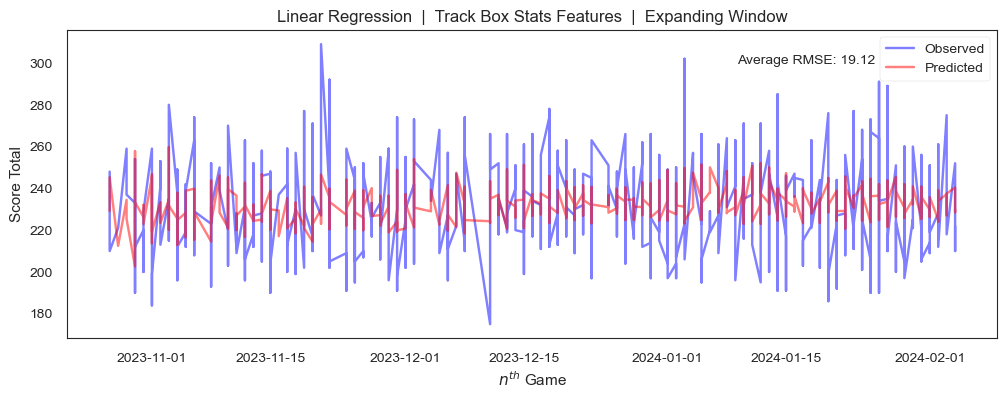

In [11]:
utl.plot_model_performance(
    title='Linear Regression  |  Track Box Stats Features  |  Expanding Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="1.2.-Rolling-Window"></a>
## 1.2. Rolling Window

[Return to top](#Baseline-Models)

In [12]:
# configuration for total points with rolling window
model = LinearRegression()  # model class
target_col = 'TOTAL_PTS'    # target column name
df = pts_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 4.86 seconds


In [13]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 19.44
- Null RMSE: 19.88


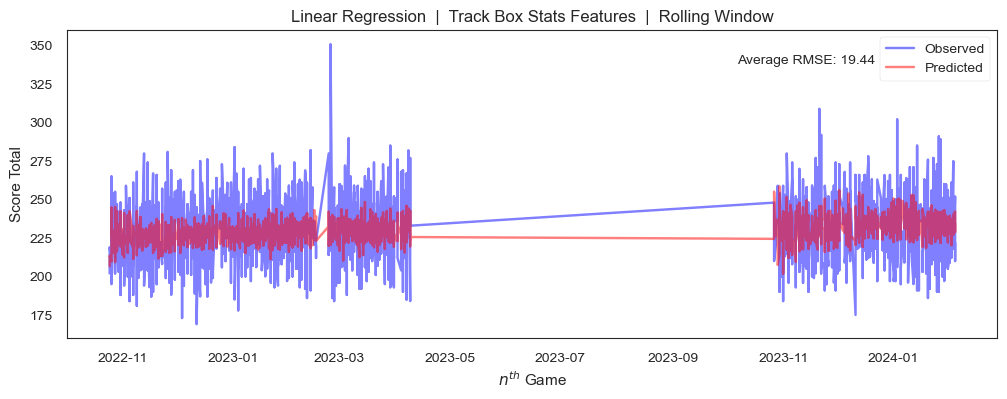

In [14]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Track Box Stats Features  |  Rolling Window',
    y_label='Score Total',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="2.-Target:-Difference-in-Points-(plus-/-minus)"></a>
# 2. Target: Difference in Points (plus / minus)

[Return to top](#Baseline-Models)

<a name="2.1.-Expanding-Window"></a>
## 2.1. Expanding Window

[Return to top](#Baseline-Models)

In [15]:
# configuration for point difference with expanding window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 2.38 seconds


In [16]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 14.34
- Null RMSE: 15.32


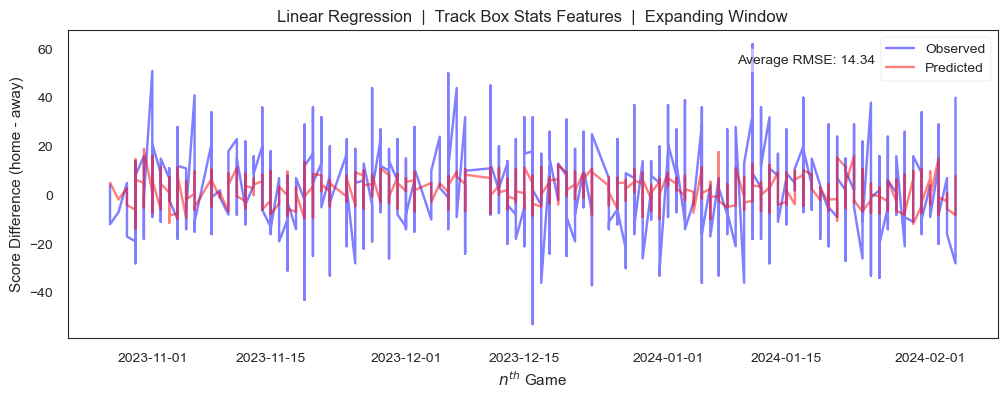

In [17]:
utl.plot_model_performance(
    title='Linear Regression  |  Track Box Stats Features  |  Expanding Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    initial_train_size=initial_train_size
)

<a name="2.2.-Rolling-Window"></a>
## 2.2. Rolling Window

[Return to top](#Baseline-Models)

In [18]:
# configuration for points difference with rolling window
model = LinearRegression()  # model class
target_col = 'PLUS_MINUS'   # target column name
df = pm_scaled_df           # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit
)

Total time taken: 4.61 seconds


In [19]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Regression Metrics:
- Average RMSE: 13.84
- Null RMSE: 14.28


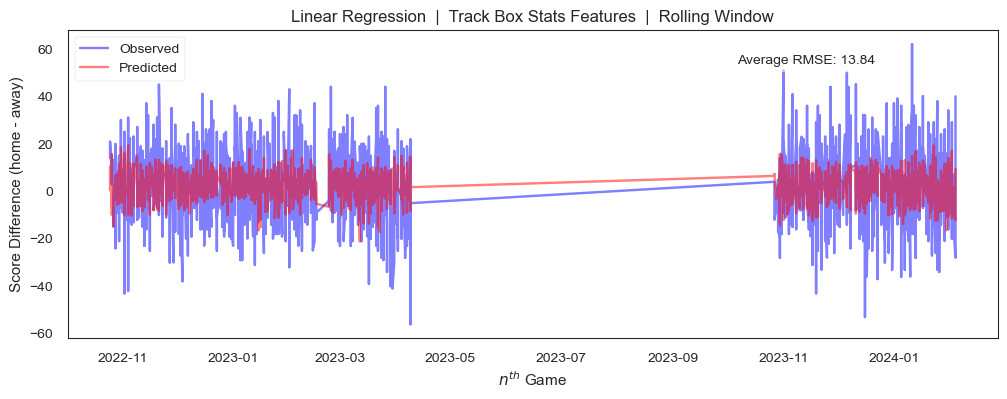

In [20]:
utl.plot_model_performance_rolling(
    title='Linear Regression  |  Track Box Stats Features  |  Rolling Window',
    y_label='Score Difference (home - away)',
    metric=metrics['average_rmse'],
    df=df, 
    model_outputs=model_outputs, 
    target_col=target_col,
    train_size=train_size
)

<a name="3.-Target:-Game-Winner-(moneyline)"></a>
# 3. Target: Game Winner (moneyline)

[Return to top](#Baseline-Models)

<a name="3.1.-Expanding-Window"></a>
## 3.1. Expanding Window

[Return to top](#Baseline-Models)

In [21]:
# configuration for game winner with expanding window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
initial_train_size = season_22_ngames + season_23_ngames # starting size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
gap_size = 0                # should there be a gap between train and test sets?
expansion_limit = None      # maximum number of new training observations in expansion

# run model
model_outputs, y_true = utl.train_with_expanding_window(
    model=model,
    target_col=target_col,
    df=df,  
    initial_train_size=initial_train_size,
    test_size=test_size, 
    gap_size=gap_size,
    expansion_limit=expansion_limit,
    ensure_diversity=True # ensure class diversity in training
)

# add predictions to test set observations
test_set_obs.loc[test_set_obs.index[gap_size:gap_size+len(model_outputs)], target_col] = model_outputs

Total time taken: 26.96 seconds


In [22]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.56
- Average Accuracy: 0.65
- Overall AUC: 0.71
- Average F1 Score: 0.70


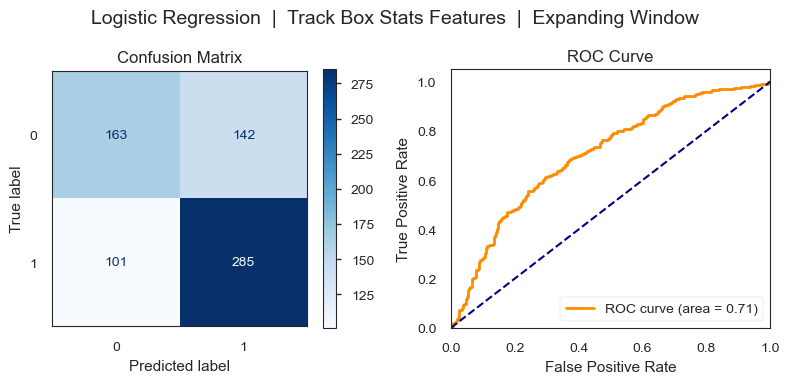

In [23]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Track Box Stats Features  |  Expanding Window'
)

In [24]:
# write out all model predictions and meta-data
test_set_obs.rename(columns={
    'TOTAL_PTS': 'TOTAL_PTS_PREDS',
    'PLUS_MINUS': 'PLUS_MINUS_PREDS',
    'GAME_RESULT': 'GAME_RESULT_PREDS'
}, inplace=True)
columns_to_round = ['TOTAL_PTS_PREDS', 'PLUS_MINUS_PREDS', 'GAME_RESULT_PREDS']
test_set_obs[columns_to_round] = test_set_obs[columns_to_round].round(4)
test_set_obs.to_csv('../../data/model_predictions/GLM_preds_playertrack_stats.csv', index=False)

<a name="3.2.-Rolling-Window"></a>
## 3.2. Rolling Window

[Return to top](#Baseline-Models)

In [25]:
# configuration for game winner with rolling window
model = LogisticRegression(penalty=None, max_iter=10000, solver='lbfgs')  # model class
target_col = 'GAME_RESULT'  # target column name
df = res_scaled_df          # data set to use
train_size = 1200           # size of the training set
test_size = 1               # leave-one-out (LOO) cross-validation
advancement_limit = None    # maximum number of times the training window is advanced

# run model
model_outputs, y_true = utl.train_with_rolling_window(
    model=model,
    target_col=target_col,
    df=df,  
    train_size=train_size,
    test_size=test_size, 
    advancement_limit=advancement_limit,
    ensure_diversity=True # ensure class diversity in training
)

Total time taken: 93.15 seconds


In [26]:
metrics = utl.calculate_metrics(y_true, model_outputs)

Classification Metrics:
- Baseline Accuracy: 0.57
- Average Accuracy: 0.61
- Overall AUC: 0.64
- Average F1 Score: 0.69


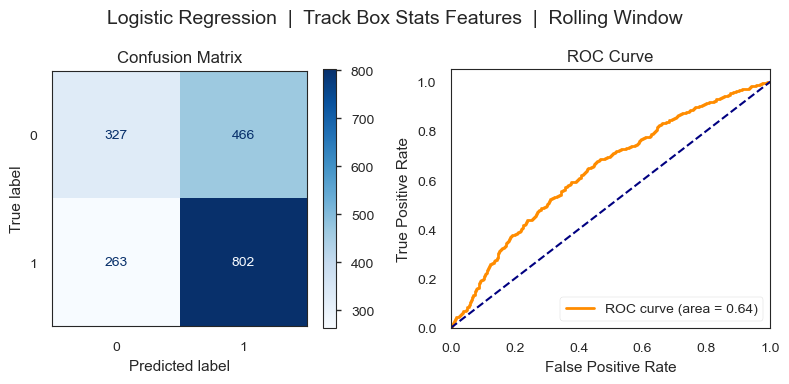

In [27]:
utl.plot_classification_performance(
    y_true=y_true, 
    model_outputs=model_outputs,
    pred_labels=metrics['pred_labels'],
    overall_title='Logistic Regression  |  Track Box Stats Features  |  Rolling Window'
)